# HW3: Feature Matching and Snakes



In this homework assignment, we will see how to use snakes to segment images and how to match features between images

In [378]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import skimage.io

%matplotlib inline

## Feature Matching

Load the exercise images:

In [379]:
im1 = cv2.imdecode(np.frombuffer(requests.get("https://drive.google.com/uc?id=1y8eKxsxxQDDxnwZex_qNi_1QtEmr7xai").content, np.uint8), cv2.IMREAD_GRAYSCALE)
im2 = cv2.imdecode(np.frombuffer(requests.get("https://drive.google.com/uc?id=1ZRNAyo9SUeL0BcTJKFzKuEku2-YTkvA9").content, np.uint8), cv2.IMREAD_GRAYSCALE)
im3 = cv2.imdecode(np.frombuffer(requests.get("https://drive.google.com/uc?id=1DPGLB1NtZiPEhSVHnVq_1yc5d5XSCEjf").content, np.uint8), cv2.IMREAD_GRAYSCALE)

Make sure the download worked

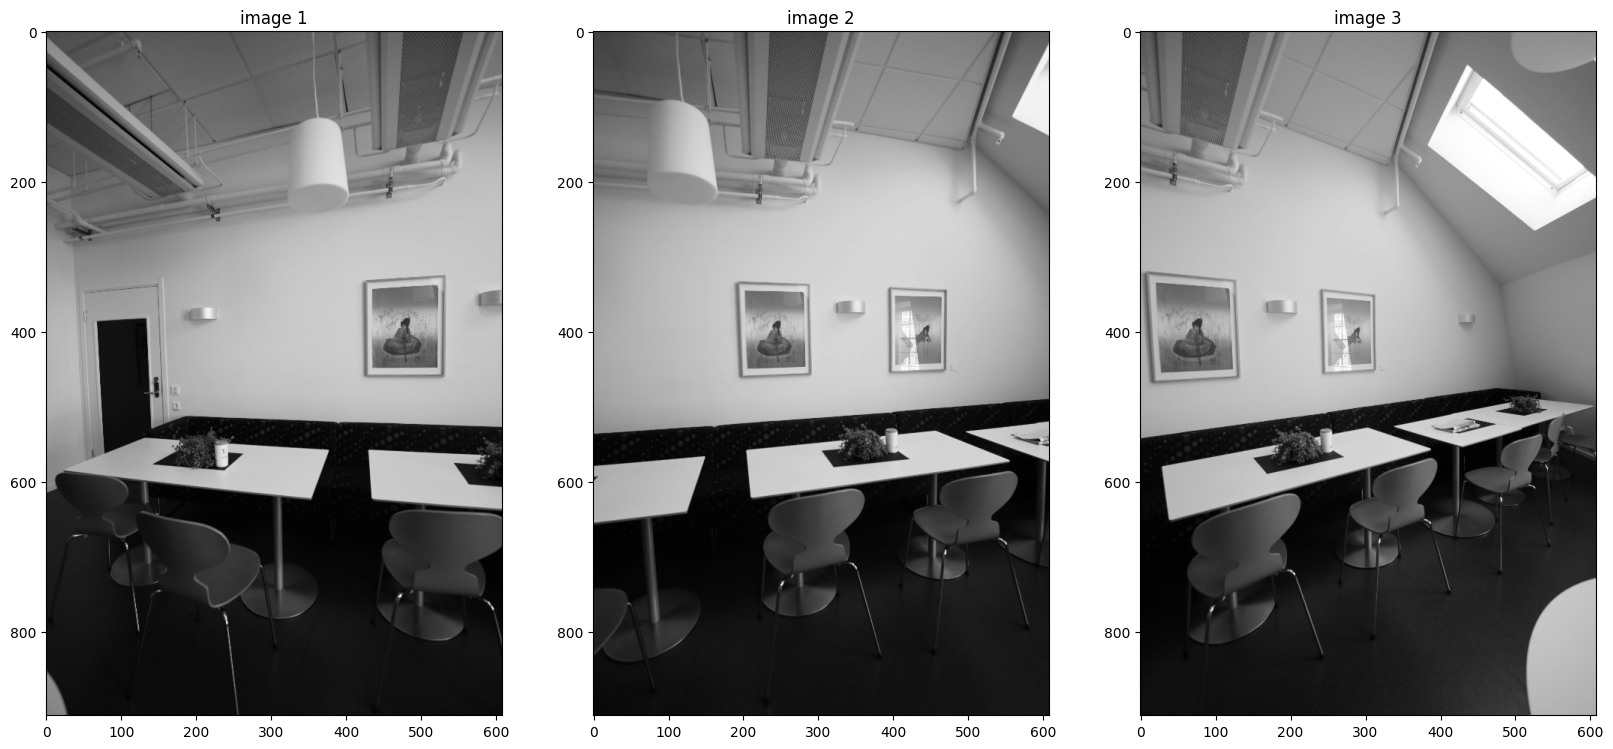

In [380]:
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(im1, cmap='gray'),plt.title('image 1')
plt.subplot(132),plt.imshow(im2, cmap='gray'),plt.title('image 2')
plt.subplot(133),plt.imshow(im3, cmap='gray'),plt.title('image 3');

Use image 1 and image 2

Extract SIFT keypoints and descriptors from both images (`cv2.xfeatures2d.SIFT_create()` and `.detectAndCompute()`).

Match the descriptors (2-nn) and apply the ratio test (`cv2.BFMatcher_create` and `.knnMatch()`)

Show the matching before and after the ratio test (`cv2.drawMatchesKnn`)

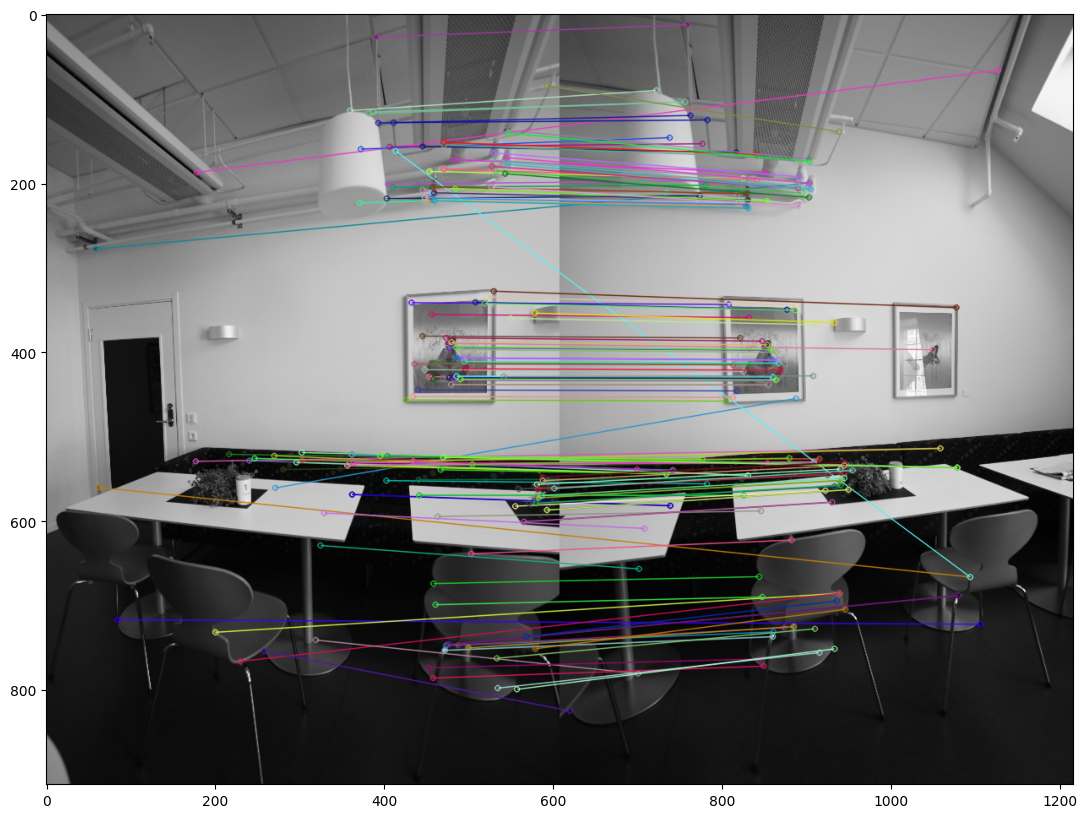

In [381]:
# extract SIFT features from the images im1 and im2
sift = cv2.SIFT_create()
kpts1,desc1 = sift.detectAndCompute(im1, None)
kpts2,desc2 = sift.detectAndCompute(im2, None)

# match features using Brute Force matcher
bf = cv2.BFMatcher_create()
matches = bf.knnMatch(desc1,desc2,k=2)

# Apply ratio test with 0.75 difference factor
good = []
for m,n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])
        
# align the "good" points in two arrays
pts1 = np.array([[0,0]]*len(good))
pts2 = np.array([[0,0]]*len(good))
for i,match in enumerate(good):
    pts1[i] = kpts1[match[0].queryIdx].pt
    pts2[i] = kpts2[match[0].trainIdx].pt
    
# show the matching before and after the ratio test
img_match = cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,good, None, flags=2)
plt.figure(figsize=(20,10))
plt.imshow(img_match)
plt.show()


This is how it should look like:

(<AxesSubplot: title={'center': 'ratio test'}>,
 Text(0.5, 1.0, 'ratio test'))

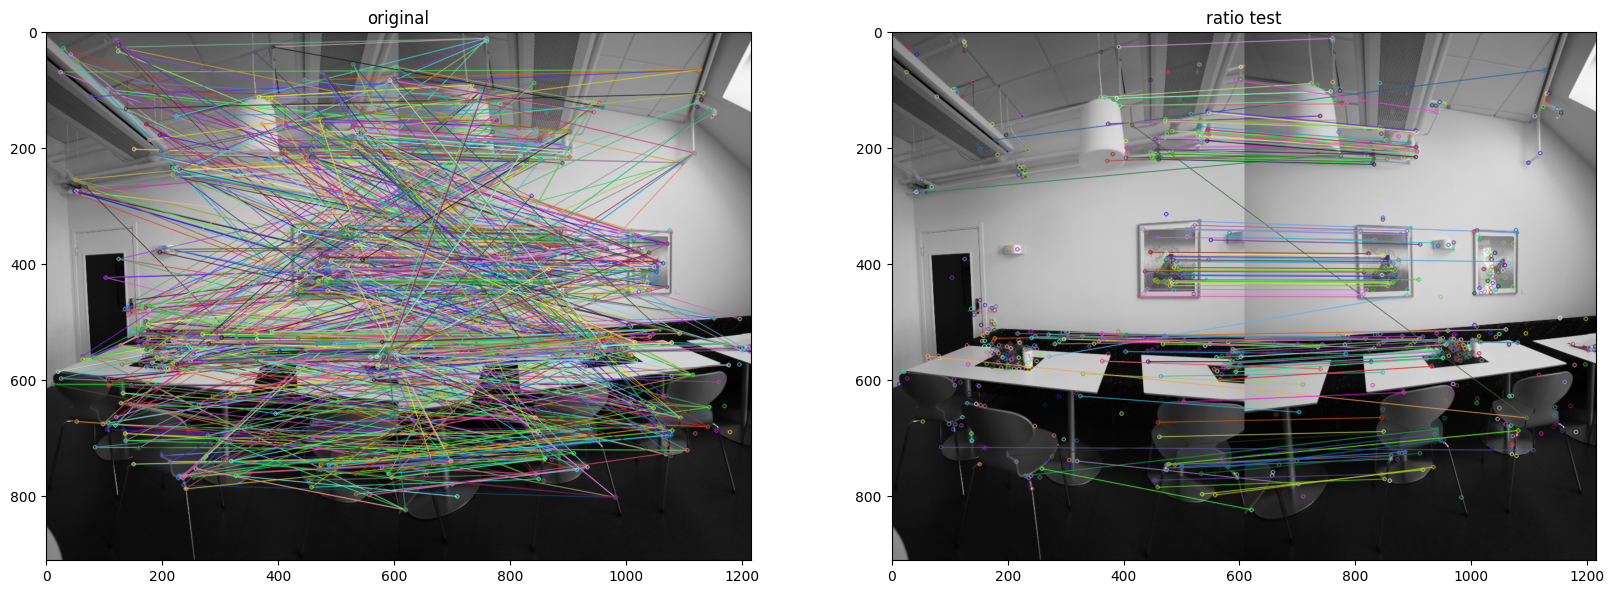

In [382]:
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,matches,im1.copy())), plt.title('original')
plt.subplot(122),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,good,im1.copy())), plt.title('ratio test')

In [383]:
good_reciprocal = []
matches2 = bf.knnMatch(desc2, desc1, 2)

for i, good_match in enumerate(good):
    for reciprocal_match, _ in matches2:
        if reciprocal_match.trainIdx == good_match[0].queryIdx and reciprocal_match.queryIdx == good_match[0].trainIdx:
            good_reciprocal.append(good_match)

pts1,pts2 = np.array([[0,0]]*len(good_reciprocal)), np.array([[0,0]]*len(good_reciprocal))
for i, match in enumerate(good_reciprocal):
    pts1[i] = kpts1[match[0].queryIdx].pt
    pts2[i] = kpts2[match[0].trainIdx].pt

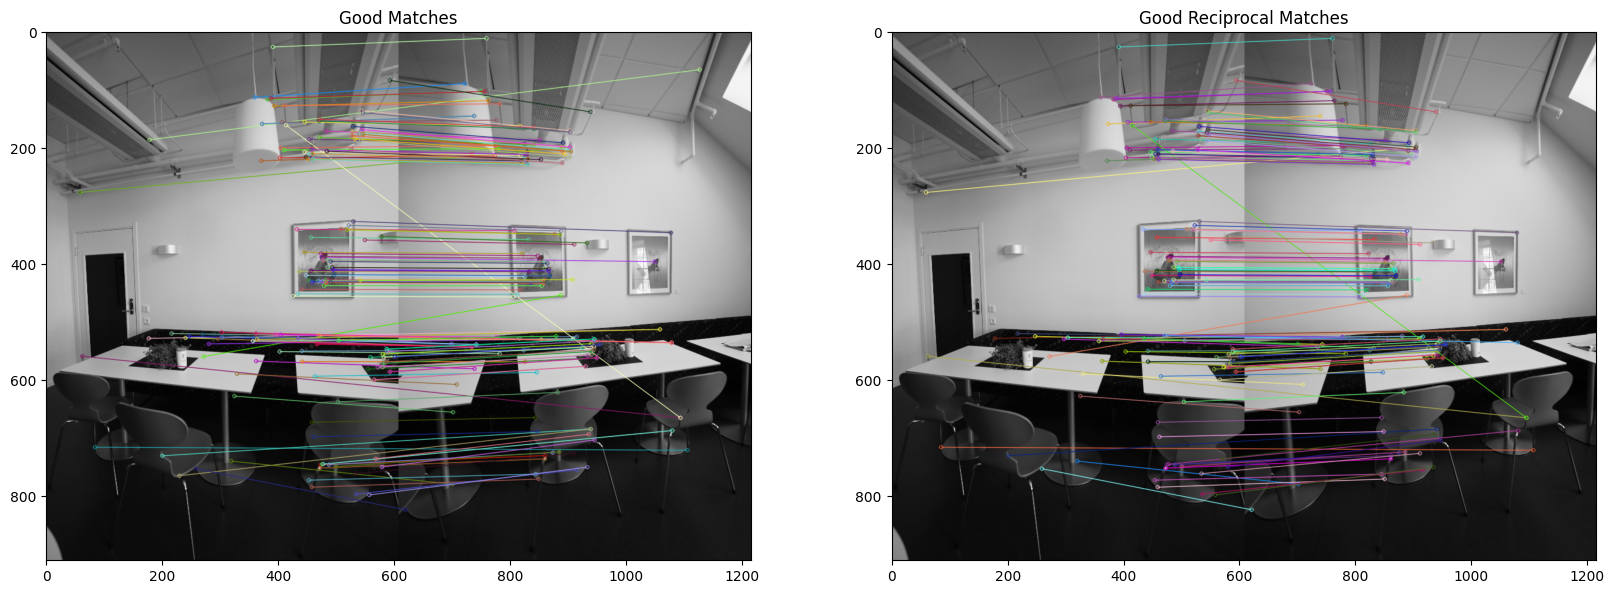

In [384]:
# Draw the matches from the "good" list
img_matches = cv2.drawMatchesKnn(im1, kpts1, im2, kpts2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Draw the matches from the "good_reciprocal" list
img_reciprocal_matches = cv2.drawMatchesKnn(im1, kpts1, im2, kpts2, good_reciprocal, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Plot the results side by side
plt.figure(figsize=(20,10))

# Plot the "good" matches
plt.subplot(121)
plt.imshow(img_matches)
plt.title("Good Matches")

# Plot the "good_reciprocal" matches
plt.subplot(122)
plt.imshow(img_reciprocal_matches)
plt.title("Good Reciprocal Matches")

# Show the plot
plt.show()


We were able to get a little bit more specificity in our matching, which is always a good thing.

## Geometric Model Fitting

Given the above matching (make sure you keep the `good` variable!)


### Affine transform

Find an affine transform using Linear Least Squares by solving a $Ax=0$ equation (use `np.linalg.svd`) and show the resulting warping (`cv2.warpAffine`).

Let $p_i^{(1)}=(x_i^{(1)},y_i^{(1)})$ and $p_i^{(2)}=(x_i^{(2)},y_i^{(2)})$ be matching points in images 1 and 2 respectively, recall:

$$
Mp_i^{(1)} =
\begin{pmatrix}
a & b & t_x \\
c & d & t_y \\
\end{pmatrix}
\begin{pmatrix}
x_i^{(1)} \\ y_i^{(1)} \\ 1
\end{pmatrix}
\mathop{=}_{\mathrm{should}}
\begin{pmatrix}
x_i^{(2)} \\ y_i^{(2)} 
\end{pmatrix}
= p_i^{(2)}
$$

So we would like to minimize the following functor

$$
E_\mathrm{affine}(P_{n}^{(1)},P_{n}^{(2)}) = \sum_i^n || Mp_i^{(1)} - p_i^{(2)} ||
$$

In terms of $M$, e.g.
$$
\hat{M} = \arg\min_{M} E_\mathrm{affine}(P_{n}^{(1)},P_{n}^{(2)})
$$

Expand the multiplication:
$$
x_i^{(2)} = ax_i^{(1)} + by_i^{(1)} + t_x\\
y_i^{(2)} = cx_i^{(1)} + dy_i^{(1)} + t_y
$$

We construct a system of equations of shape $Ax=b$:
$$
\begin{pmatrix}
& \cdots & \\ 
x_i^{(1)} & y_i^{(1)} & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & x_i^{(1)} & y_i^{(1)} & 1 \\
& \cdots & 
\end{pmatrix}
\begin{pmatrix}
a \\ b \\ t_x \\ c \\ d \\ t_y
\end{pmatrix}
\mathop{=}_{\mathrm{should}}
\begin{pmatrix}
\cdots \\ x_i^{(2)} \\ y_i^{(2)} \\ \cdots 
\end{pmatrix}
$$

---

In [385]:
def findAffineLLSQ(ptsLeft, ptsRight):
    # create the A matrix, which is a 2n x 6 matrix, where n is the number of points
    A = np.zeros((2 * len(ptsLeft), 6), dtype=np.float32)
    # create a b vector, which is a 2n x 1 vector (column vector) of zeros with the same length as the A matrix rows
    b = np.zeros((2 * len(ptsLeft), 1), dtype=np.float32)

    for i in range(len(ptsLeft)):
        # Get the left and right points
        xil,yil = ptsLeft[i]
        xir,yir = ptsRight[i]

        # Populate the A matrix with the following two rows for each point
        A[2 * i, :] = [xil,yil,1,0,0,0]
        A[2 * i + 1, :] = [0,0,0,xil,yil,1]

        # Populate the b vector with the following two rows for each point
        b[2 * i, 0] = xir
        b[2 * i + 1, 0] = yir

    # Solve the linear system of equations using np.linalg.lstsq
    result, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    # Reshape the result to a 2x3 matrix
    result = np.reshape(result, (2, 3))
    return result


In [386]:
# a utility for warping and blending images using an affine transformation matrix
def warpAndblendImagesAffine(image1,image2,M):
    h_,w_ = image1.shape
    im2warp = cv2.warpAffine(image2, M, (w_,h_), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_CONSTANT)
    im2mask = cv2.warpAffine(np.ones_like(image2), M, (w_,h_), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_CONSTANT)
    return image1 * (1.0 - im2mask) + im2warp * im2mask

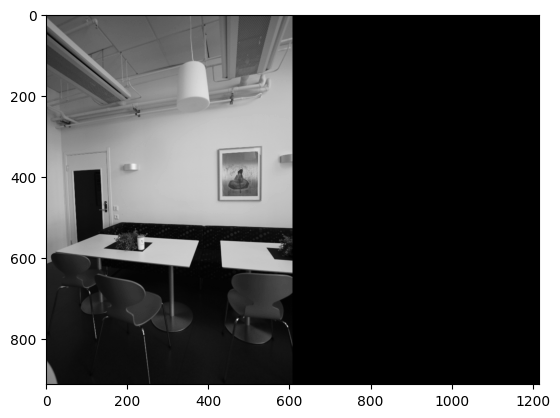

In [387]:
# make a copy of image 1 with room on the right for image 2
im1wide = np.hstack([im1, np.zeros_like(im1)])

# display the im1wide image
plt.imshow(im1wide, cmap='gray')

[[ 2.0012304e-01  9.9137738e-02  1.2282302e+02]
 [-3.6624204e-02  9.3272591e-01  4.7680122e+01]]


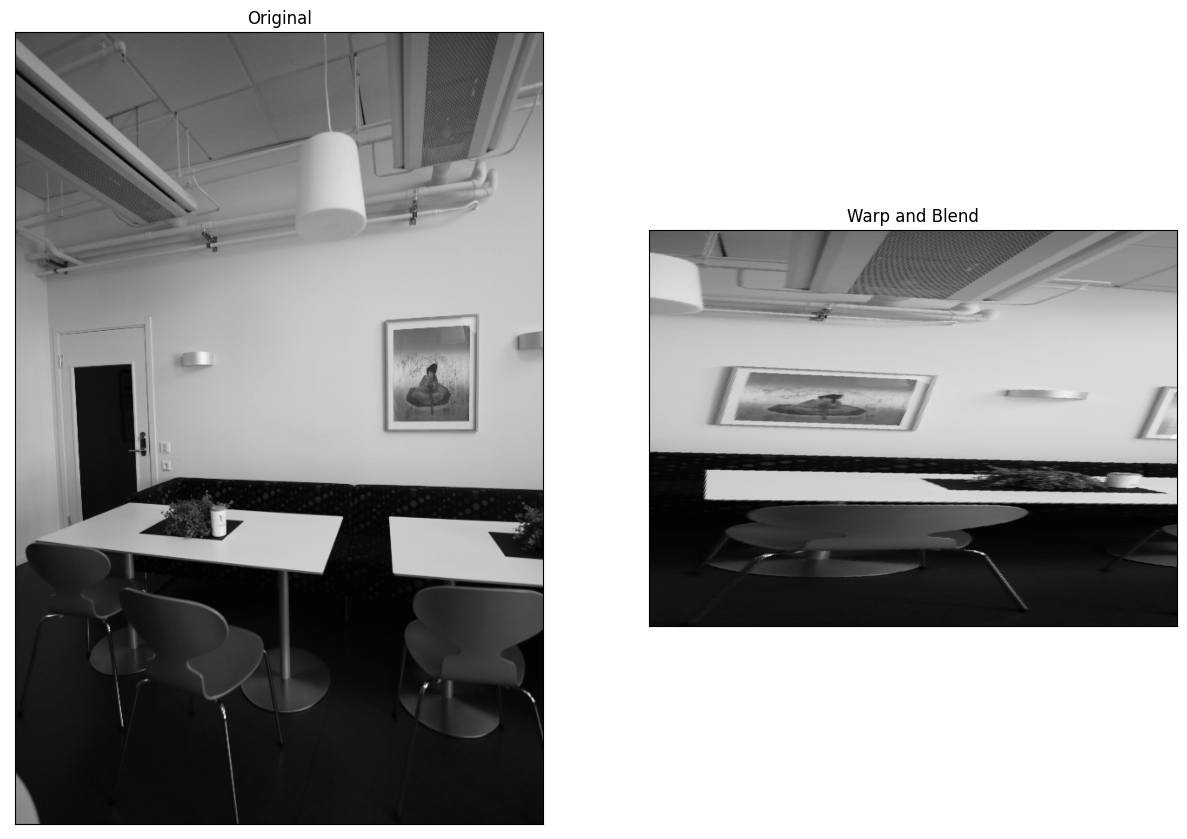

In [388]:
# use the findAffineLLSQ function to find the affine transformation matrix between the two images using the pts1 and pts2 arrays
M = findAffineLLSQ(pts1, pts2)
print(M)

# show the result using warpAndBlendImagesAffine side by side with the original image
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(im1, cmap='gray')
plt.title("Original"), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(warpAndblendImagesAffine(im1wide, im2, M), cmap='gray')
plt.title("Warp and Blend"), plt.xticks([]), plt.yticks([])
plt.show()

This is looking pretty bad. Not even close!

Let's try OpenCV's method that can apply the RANSAC method for eliminating outliers

In [389]:
# Let's try OpenCV's method that can apply the RANSAC method for eliminating outliers
# Use cv2.estimateAffine2D to find the affine transformation matrix using the pts1 and pts2 arrays
# RANSAC will be the default method
M, mask = cv2.estimateAffine2D(pts1, pts2)

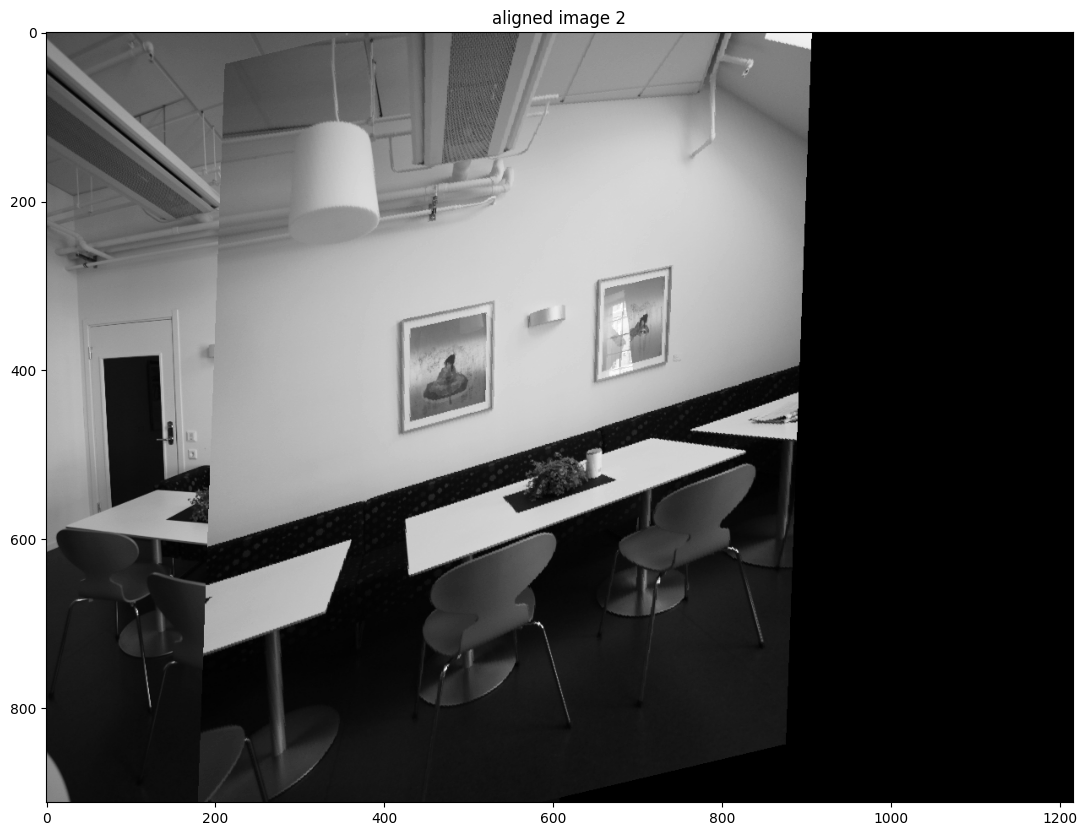

In [390]:
plt.figure(figsize=(20,10))
plt.imshow(warpAndblendImagesAffine(im1wide, im2, M), cmap='gray'), plt.title('aligned image 2');

Eeef . Still pretty bad. 

Let's look at which point-pairs have survived the affine RANSAC:

Text(0.5, 1.0, 'Masked 40 matches')

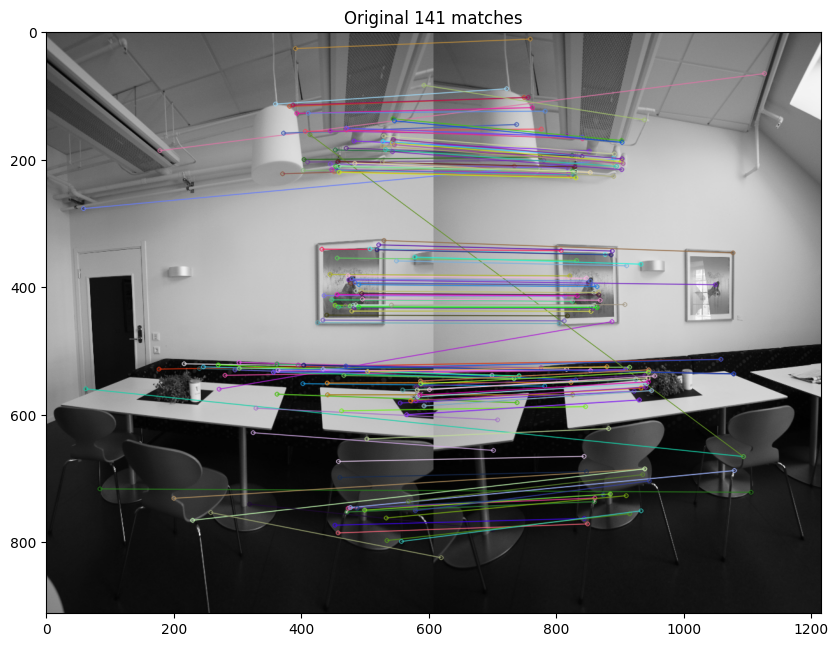

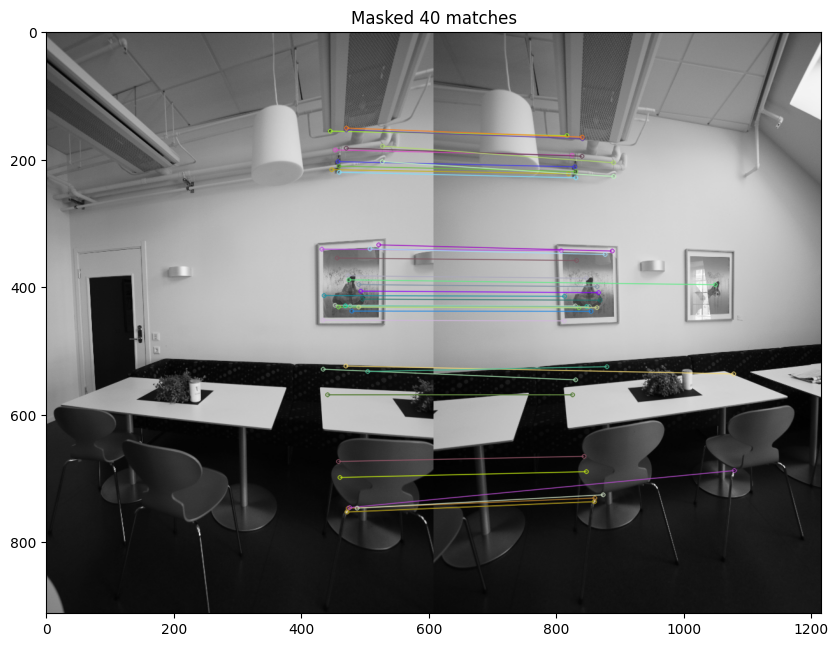

In [391]:
good_masked = [match for i, match in enumerate(good) if i < len(mask) and mask[i] == 1]

plt.figure(figsize=(10, 10))
plt.imshow(cv2.drawMatchesKnn(im1, kpts1, im2, kpts2, good, None, flags=2))
plt.title("Original 141 matches")

plt.figure(figsize=(10, 10))
plt.imshow(cv2.drawMatchesKnn(im1, kpts1, im2, kpts2, good_masked, None, flags=2))
plt.title("Masked 40 matches")

Very little points. No wonder, the affine transformation is not a good fit for this problem. We need to find a homography

### Homography

Find a homography using unconstrained Linear Least Squares by solving a $AX=0$ equation, and show the resulting homography warping (`cv2.warpPerspective`).

Consider $p_i^{(1)}=(x_i^{(1)},y_i^{(1)})$ and $p_i^{(2)}=(x_i^{(2)},y_i^{(2)})$ our matching points. 

We can formulate the problem as such:
$$
\begin{pmatrix}
h_1 & h_2 & h_3 \\
h_4 & h_5 & h_6 \\
h_7 & h_8 & h_9
\end{pmatrix}
\begin{pmatrix}
x_i^{(1)} \\ y_i^{(1)} \\ 1
\end{pmatrix}
\mathop{=}_{\mathrm{should}}
\lambda
\begin{pmatrix}
x_i^{(2)} \\ y_i^{(2)} \\ 1
\end{pmatrix}
=
\begin{pmatrix}
\lambda x_i^{(2)} \\ \lambda y_i^{(2)} \\ \lambda
\end{pmatrix}
\,\,\,,\,\,\,
\hat{x_i^{(2)}} = x_i^{(2)} / \lambda\,\,\,, \,\,\,
\hat{y_i^{(2)}} = y_i^{(2)} / \lambda
$$
$$
\hat{x_i^{(2)}} = \frac{h_1x_i^{(1)}+h_2y_i^{(1)}+h_3}{h_7x_i^{(1)}+h_8y_i^{(1)}+h_9}
\,\,\,, \,\,\,
\hat{y_i^{(2)}} = \frac{h_4x_i^{(1)}+h_5y_i^{(1)}+h_6}{h_7x_i^{(1)}+h_8y_i^{(1)}+h_9}
$$
$$
h_7\hat{x_i^{(2)}}x_i^{(1)}+h_8\hat{x_i^{(2)}}y_i^{(1)}+h_9\hat{x_i^{(2)}} - h_1x_i^{(1)} - h_2y_i^{(1)} - h_3 = 0\\
h_7\hat{y_i^{(2)}}x_i^{(1)}+h_8\hat{y_i^{(2)}}y_i^{(1)}+h_9\hat{y_i^{(2)}} - h_4x_i^{(1)} - h_5y_i^{(1)} - h_6 = 0
$$
And thus:
$$
\begin{pmatrix}
& \cdots & \\
-x_i^{(1)} & -y_i^{(1)} & -1 & 0 & 0 & 0 & \hat{x_i^{(2)}}x_i^{(1)} & \hat{x_i^{(2)}}y_i^{(1)} & \hat{x_i^{(2)}} \\
0 & 0 & 0 & -x_i^{(1)} & -y_i^{(1)} & -1 & \hat{y_i^{(2)}}x_i^{(1)} & \hat{y_i^{(2)}}y_i^{(1)} & \hat{y_i^{(2)}}  \\
& \cdots & 
\end{pmatrix}
\begin{pmatrix}
h_1 \\ h_2 \\ h_3 \\
h_4 \\ h_5 \\ h_6 \\
h_7 \\ h_8 \\ h_9
\end{pmatrix}
\mathop{=}_{\mathrm{should}}
\begin{pmatrix}
\cdots \\ 0 \\ 0 \\ \cdots 
\end{pmatrix}
$$

In [392]:
# a utility for warping and blending images using a homography matrix
def warpAndblendImagesHomography(image1,image2,H):
    h_,w_ = image1.shape
    im2warp = cv2.warpPerspective(image2, H, (w_,h_), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_CONSTANT)
    im2mask = cv2.warpPerspective(np.ones_like(image2), H, (w_,h_), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_CONSTANT)
    return image1 * (1.0 - im2mask) + im2warp * im2mask

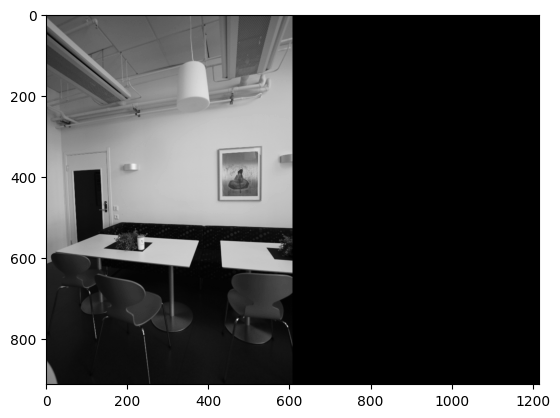

In [393]:
# make a copy of image 1 with room on the right for image 2
im1wide = np.hstack([im1, np.zeros_like(im1)])

# display the im1wide image
plt.imshow(im1wide, cmap='gray')

Implement and Run the LLSQ method for finding homography

In [394]:
# homogeneous linear least squares solution for finding a homography
def findHomographyLLSQ(ptsLeft, ptsRight):
    # create the A matrix, which is a 2n x 9 matrix, where n is the number of points
    # use np.repeat to create a 2n x 9 matrix of zeros (np.zeros) with the same length as the ptsLeft array
    n = len(ptsLeft)
    A = np.zeros((2*n, 9))

    for i in range(len(ptsLeft)):
        # TODO: your code, populate the A matrix
        # hint: use the ptsLeft and ptsRight arrays to get the points, and use the i index to put the points in the correct row
        # e.g. x,y = ptsLeft[i] will give you the left point, and x,y = ptsRight[i] will give you the right point
        
        xil,yil = ptsLeft[i]
        xir,yir = ptsRight[i]

        # according to the guidance above, we need to populate the A matrix with the following two rows for each point:
        #  [-xL -yL -1 0 0 0 xR*xL xR*yL xR]
        #  [0 0 0 -xL -yL -1 yR*xL yR*yL yR]
        # the row index can be figured out using the i index
        A[2*i,:] = [-xil, -yil, -1, 0, 0, 0, xir*xil, xir*yil, xir]
        A[2*i+1,:] = [0, 0, 0, -xil, -yil, -1, yir*xil, yir*yil, yir]

    # take the SVD of A (`np.linalg.svd`) and pick the last row of Vt (last column of V)
    # TODO: your code here...
    u,z,vt = np.linalg.svd(A)
    # the last row of Vt is the solution to the homogeneous (Ax=0) linear least squares problem
    # reshape the vector back to a 3,3 matrix
    H_vec = vt[-1,:]
    # normalize the last element to 1 (homogeneous coordinates) by dividing H by the last [2,2] element of H
    H = H_vec.reshape((3,3))
    return H

In [395]:
# use the findHomographyLLSQ function you wrote to find the homography matrix
# using the pts1 and pts2 arrays
H = findHomographyLLSQ(pts1, pts2)
print(H)
# get the result using warpAndBlendImagesHomography
lstsqWarp = warpAndblendImagesHomography(im1, im2, H)

[[-1.12719367e-03 -1.90036341e-04  5.07061885e-01]
 [-1.70078002e-03 -5.55764760e-04  8.61906065e-01]
 [-3.02764069e-06 -5.43657753e-07  1.29335393e-03]]


Now find a homography using RANSAC (`M, mask = cv2.findHomography`), show only the inliers pair-matches that survived RANSAC as well as the final warping

In [396]:
H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC)
print(H)
findHomogWarp = warpAndblendImagesHomography(im1, im2, H)

[[ 2.25288465e+00  6.88030137e-02 -6.20033513e+02]
 [ 8.46456257e-01  1.87469915e+00 -3.59171669e+02]
 [ 2.01151853e-03  3.00462267e-05  1.00000000e+00]]


Display the results

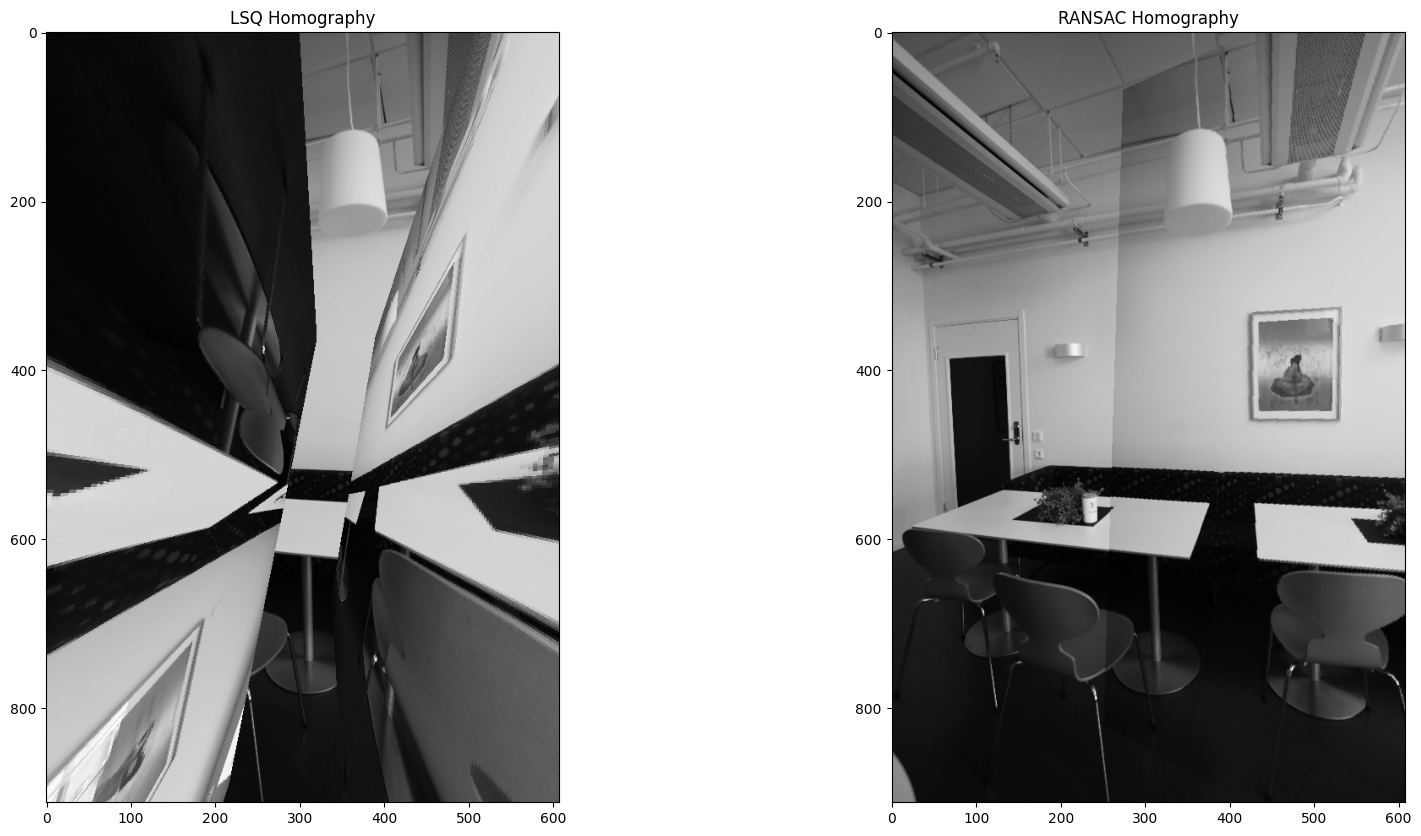

In [397]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(lstsqWarp, cmap = 'gray')
plt.title("LSQ Homography")
plt.subplot(122)
plt.imshow(findHomogWarp, cmap = 'gray')
plt.title("RANSAC Homography")
plt.show()

What was the method that produced the best (valid) image alignment result?

In [398]:
# Geometric model fitting in my opinion

It seems that even a small proportion of outliers in the matching can cause *devastating* results.

Remember that we have the `mask` of inlier points that were included in the final homography calculation

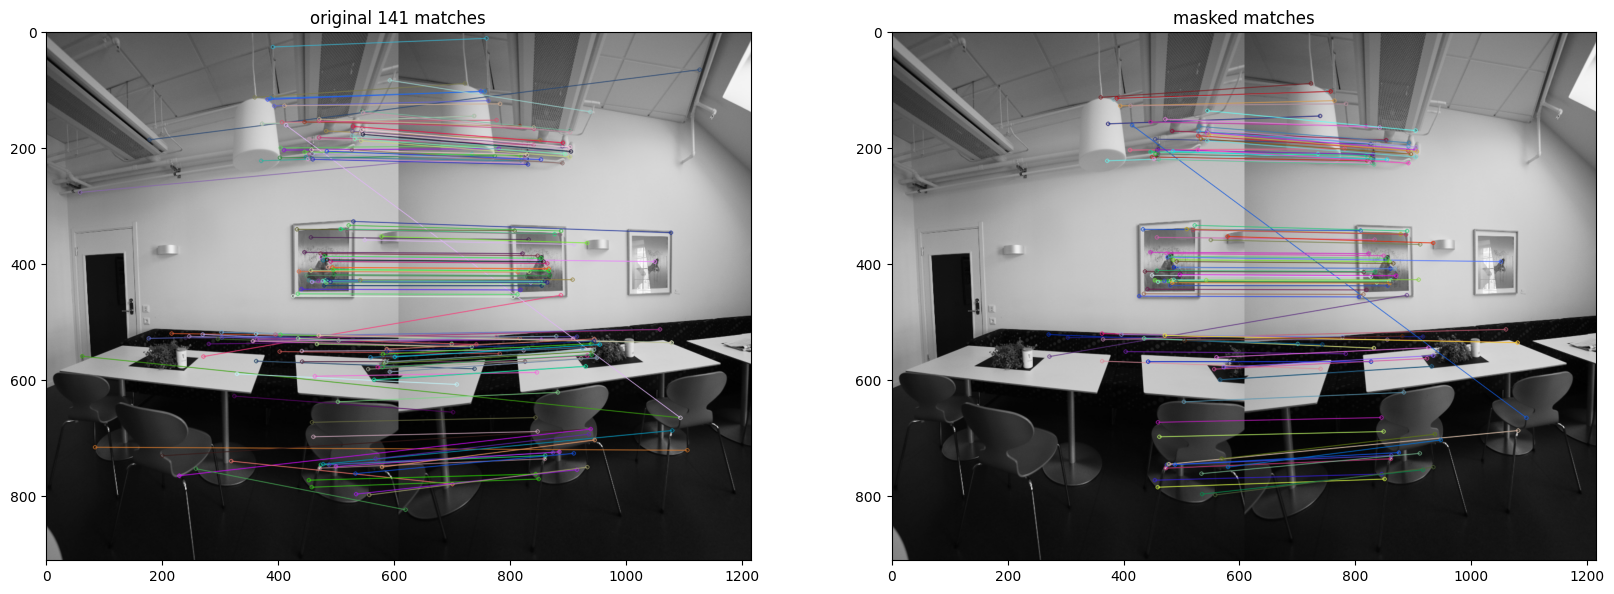

In [399]:
# prune the matches with the `mask` using the same method as above
good_masked = []
for i, flag in enumerate(mask):
    if flag == 1:
        good_masked.append(good[i])

# show the masked matchings between the two images (the ones that were used to find the homography)
# using the cv2.drawMatchesKnn function and the good_masked list
# show the "good" matches and the "good_masked" matches side by side in a 1x2 subplot
plt.figure(figsize=(20,10))
plt.subplot(121)
img_good_matches = cv2.drawMatchesKnn(im1, kpts1, im2, kpts2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_good_matches)
plt.title('original 141 matches')
plt.subplot(122)
img_masked_matches = cv2.drawMatchesKnn(im1, kpts1, im2, kpts2, good_masked, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_masked_matches)
plt.title('masked matches')
plt.show()

try running `findHomographyLLSQ` again with the mask:

[[ 2.26727160e+00  6.68655393e-02 -6.24663413e+02]
 [ 8.54344619e-01  1.87858456e+00 -3.62063857e+02]
 [ 2.02990113e-03  2.45221522e-05  1.00000000e+00]]


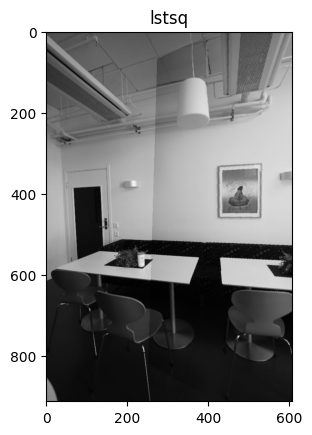

In [400]:
# try running `findHomographyLLSQ` again with the mask:
# apply the mask to the points to get the inliers (the points that were used to find the homography)
# by using the mask to index into the pts1 and pts2 arrays, e.g. pts1[mask[:,0]==1]
pts1_inliers = pts1[mask[:,0]==1]
pts2_inliers = pts2[mask[:,0]==1]
H, status = cv2.findHomography(pts1_inliers, pts2_inliers, cv2.RANSAC, 5.0)
print(H)

# warp and blend the images using the homography matrix using the warpAndblendImagesHomography function
lstsqWarp = warpAndblendImagesHomography(im1,im2,H)

plt.imshow(lstsqWarp, cmap='gray'), plt.title('lstsq');

Is it looking better now? :)

## Snakes

Let's load our class favorite - the seagull image.
We will attempt to segment its eye using a simple active contour - a "snake" like we've seen in class.

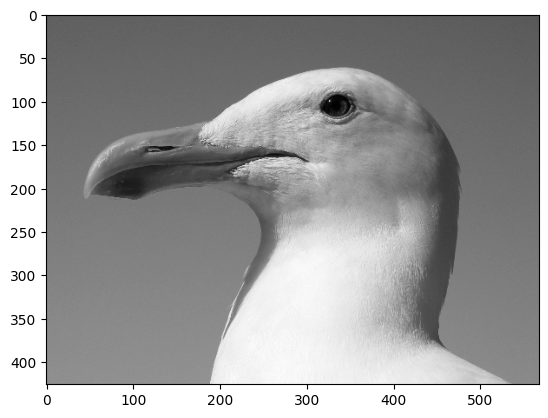

In [401]:
# load the image from the url https://upload.wikimedia.org/wikipedia/commons/9/9a/Gull_portrait_ca_usa.jpg using skimage.io.imread
# and convert it to grayscale
im1 = skimage.io.imread('https://upload.wikimedia.org/wikipedia/commons/9/9a/Gull_portrait_ca_usa.jpg')
im1 = skimage.color.rgb2gray(im1)
# scale down the image to 1/4 of its original size using cv2.resize
im1 = cv2.resize(im1, (0,0), fx=0.25, fy=0.25)

# show the image
plt.imshow(im1, cmap='gray')

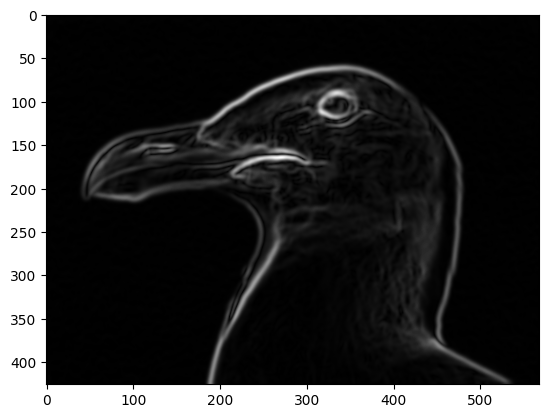

In [402]:
# find the gradient magnitude using the cv2.Sobel function (use the cv2.CV_64F datatype) in both x and y directions
# and the cv2.magnitude function to get the magnitude
# use a kernel size of 25
dx = cv2.Sobel(im1, cv2.CV_64F, 1, 0, ksize=25)
dy = cv2.Sobel(im1, cv2.CV_64F, 0, 1, ksize=25)
mag = cv2.magnitude(dx, dy)

# show the gradient magnitude image
plt.imshow(mag, cmap='gray')

(150.0, 60.0)

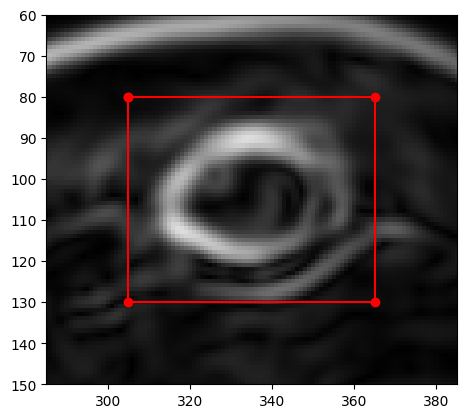

In [403]:
# consider a rectangular curve around the gull's eye
# (adding the first point to the end of the curve to close the curve)
curve = np.array([[305, 80], [365, 80], [365, 130], [305, 130], [305, 80]], np.float32)

# show the image with the curve 
plt.imshow(mag, cmap='gray')
plt.plot(curve[:,0], curve[:,1], 'r-')
plt.scatter(curve[:,0], curve[:,1], c='r')
# crop the figure to the bounding box of the curve
plt.xlim(curve[:,0].min() - 20, curve[:,0].max() + 20)
plt.ylim(curve[:,1].max() + 20, curve[:,1].min() - 20)

In [404]:
def arcLength(curve):
    # calculate the difference between each point and the next point
    diff = np.diff(curve, axis=0)
    # calculate the square of the difference in x and y
    diff_sq = diff ** 2
    diff_sq_x_and_y = np.sum(diff_sq, axis=1)
    # calculate the square root of the sum of the two squares
    diff_root = np.sqrt(diff_sq_x_and_y)
    # calculate the cumulative sum of the distances with the np.cumsum function
    dist_ = np.insert(np.cumsum(diff_root), 0, 0)
    # normalize the distances to be between 0 and 1
    dist_ = dist_ / dist_[-1]
    return dist_

def resampleCurveUniform(curve, num_points=None):
    len_crv = curve.shape[0] if num_points is None else num_points
    # calculate the arc distance for each point in the curve with the arcLength function
    dist_ = arcLength(curve)
    # resample a "distancing" array between 0 and 1 with the same length as the curve (len_crv)
    dist_resampled = np.linspace(0, 1, len_crv)
    # resample the curve using the "distancing" array
    x_resampled = np.interp(dist_resampled, dist_, curve[:, 0])
    y_resampled = np.interp(dist_resampled, dist_, curve[:, 1])
    # return the resampled curve as an array of shape (len_crv, 2): [[x1, y1], [x2, y2], ...
    return np.array([x_resampled, y_resampled]).T

(150.0, 60.0)

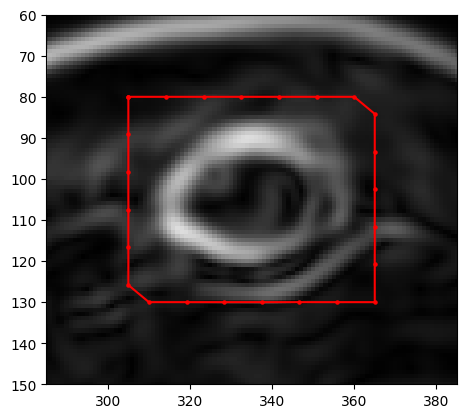

In [405]:
# resample the curve using the np.interp function to have 25 points
# (use the dist array as the x-coordinates)
# the y-coordinates are the first and second columns of the curve array
curve_resampled = resampleCurveUniform(curve, 25)

# show the image with the resampled curve with points (use plt.scatter and plt.plot for the curve)
plt.imshow(mag, cmap='gray')
plt.scatter(curve_resampled[:,0], curve_resampled[:,1], c='r', s=5)
plt.plot(curve_resampled[:,0], curve_resampled[:,1], 'r-')
# crop the figure to the bounding box of the curve
plt.xlim(curve_resampled[:,0].min() - 20, curve_resampled[:,0].max() + 20)
plt.ylim(curve_resampled[:,1].max() + 20, curve_resampled[:,1].min() - 20)

In [406]:
# this function calculates the energy function for a window around a point
# the first term is the gradient magnitude at the point and the second term is the 
# elasticity term (alpha * first curve derivative + beta * second curve derivative)
def calculateWindowEnergyFunction(
    point, next_point, prev_point, 
    gradient_image_,
    window_size=20, 
    alpha=0.05,
    beta=0.05
    ):

    # half the window size (integer division)
    win_half = window_size // 2

    # TODO: your code here...

    # get a patch of size WxW around the point of the gradient_image_ array
    # use the point variable, point = (x, y), so the patch is gradient_image_[y-W/2:y+W/2+1, x-W/2:x+W/2+1]
    patch = gradient_image_[int(point[1]-win_half):int(point[1]+win_half+1), int(point[0]-win_half):int(point[0]+win_half+1)]
    # normalize the patch to the range [0, 1] with cv2.normalize and cv2.NORM_MINMAX
    patch = cv2.normalize(patch, None, 0, 1, cv2.NORM_MINMAX)

    # for each point in the window, calculate the first derivative in terms of the curve
    # e.g. the distance between the point and the next point in the curve
    # as well as the second derivative in terms of the curve, which is the difference 
    # in distance between the point and the next point, and the point and the previous point
    # use the alpha and beta parameters to weight the two terms
    # do this for every point in the window/patch
    elasticity_term_energy = np.zeros_like(patch)
    for y in range(patch.shape[0]):
        for x in range(patch.shape[1]):
            # calculate the global coordinates of the point in the window
            # use the np.array function to create an array from the x and y coordinates
            # subtract the window half size, and add the point coordinates
            window_point_global_coordinates = np.array([x, y]) - win_half + point
            # calculate the energy term for the point in the window
            # use the np.linalg.norm function to calculate the squared euclidean distance
            # the first derivative is the distance between the point and the next point
            # the second derivative is the difference in distances
            # don't forget to multiply the two terms with the alpha and beta parameters
            elasticity_term_energy[y, x] = \
                alpha * np.linalg.norm(window_point_global_coordinates - next_point) + \
                beta * (np.linalg.norm(window_point_global_coordinates - next_point) - \
                        np.linalg.norm(window_point_global_coordinates - prev_point))
    # normalize the energy term to the range [0, 1] for good measure
    elasticity_term_energy = cv2.normalize(elasticity_term_energy, None, 0, 1, cv2.NORM_MINMAX)

    # add the weighted distance to the patch, negate it because we want to find a maximum
    patch += -elasticity_term_energy 

    return patch


def findMaximumInPatch(patch, point):
    # find the maximum value in the patch with np.max
    # and return the coordinates of the maximum value
    max_value_in_patch = np.max(patch)
    # find the point of the maximal gradient magnitude in the window using np.argwhere
    # add the offset of the window to the point of the maximal gradient magnitude
    # np.argwhere returns an array of shape (1, 2), so we need to take the first element
    max_gradient_magnitude_index = np.argwhere(patch == max_value_in_patch)[0]
    # offset the patch coordinates to the global coordinates of the image
    # subtract the window half size (patch.shape[0] // 2), and add the point coordinates
    max_idx = max_gradient_magnitude_index + point - (patch.shape[0] // 2)
    return max_idx

In [407]:
# calculate the energy function for the all points in the curve
# use the calculateWindowEnergyFunction function
# and display the patches with the maximum value in the patch (use plt.imshow) in a grid
# (use plt.subplot)
# use the findMaximumInPatch function to find the maximum value in the patch
# and display the maximum value in the patch with a red dot (use plt.scatter)
def showEnergyFunctionPatches(curve_, mag_, window_size=20, alpha=0.05, beta=0.05):
    plt.figure(figsize=(15,15))
    for i in range(curve_.shape[0]):
        patch = calculateWindowEnergyFunction(
            curve_[i], 
            curve_[(i+1)%curve_.shape[0]], 
            curve_[(i-1)], 
            mag_, 
            window_size=window_size,
            alpha=alpha,
            beta=beta)
        plt.subplot(5, 5, i+1)
        plt.imshow(patch, cmap='gray')
        plt.axis('off')
        w2 = patch.shape[0] // 2
        max_idx = findMaximumInPatch(patch, curve_[i]) + w2 - curve_[i]
        # show an arrow from the center of the patch to the maximum value in the patch
        plt.arrow(w2, w2, max_idx[0]-w2, max_idx[1]-w2, color='b', head_width=1, head_length=1)
        plt.scatter(max_idx[0], max_idx[1], c='r', s=10)
        # in the title, show the index of the point in the curve and the norm of the vector
        # from the center of the patch to the maximum value in the patch
        plt.title('Point %d (%.2f)' % (i, np.linalg.norm(max_idx - w2)))
    plt.tight_layout()

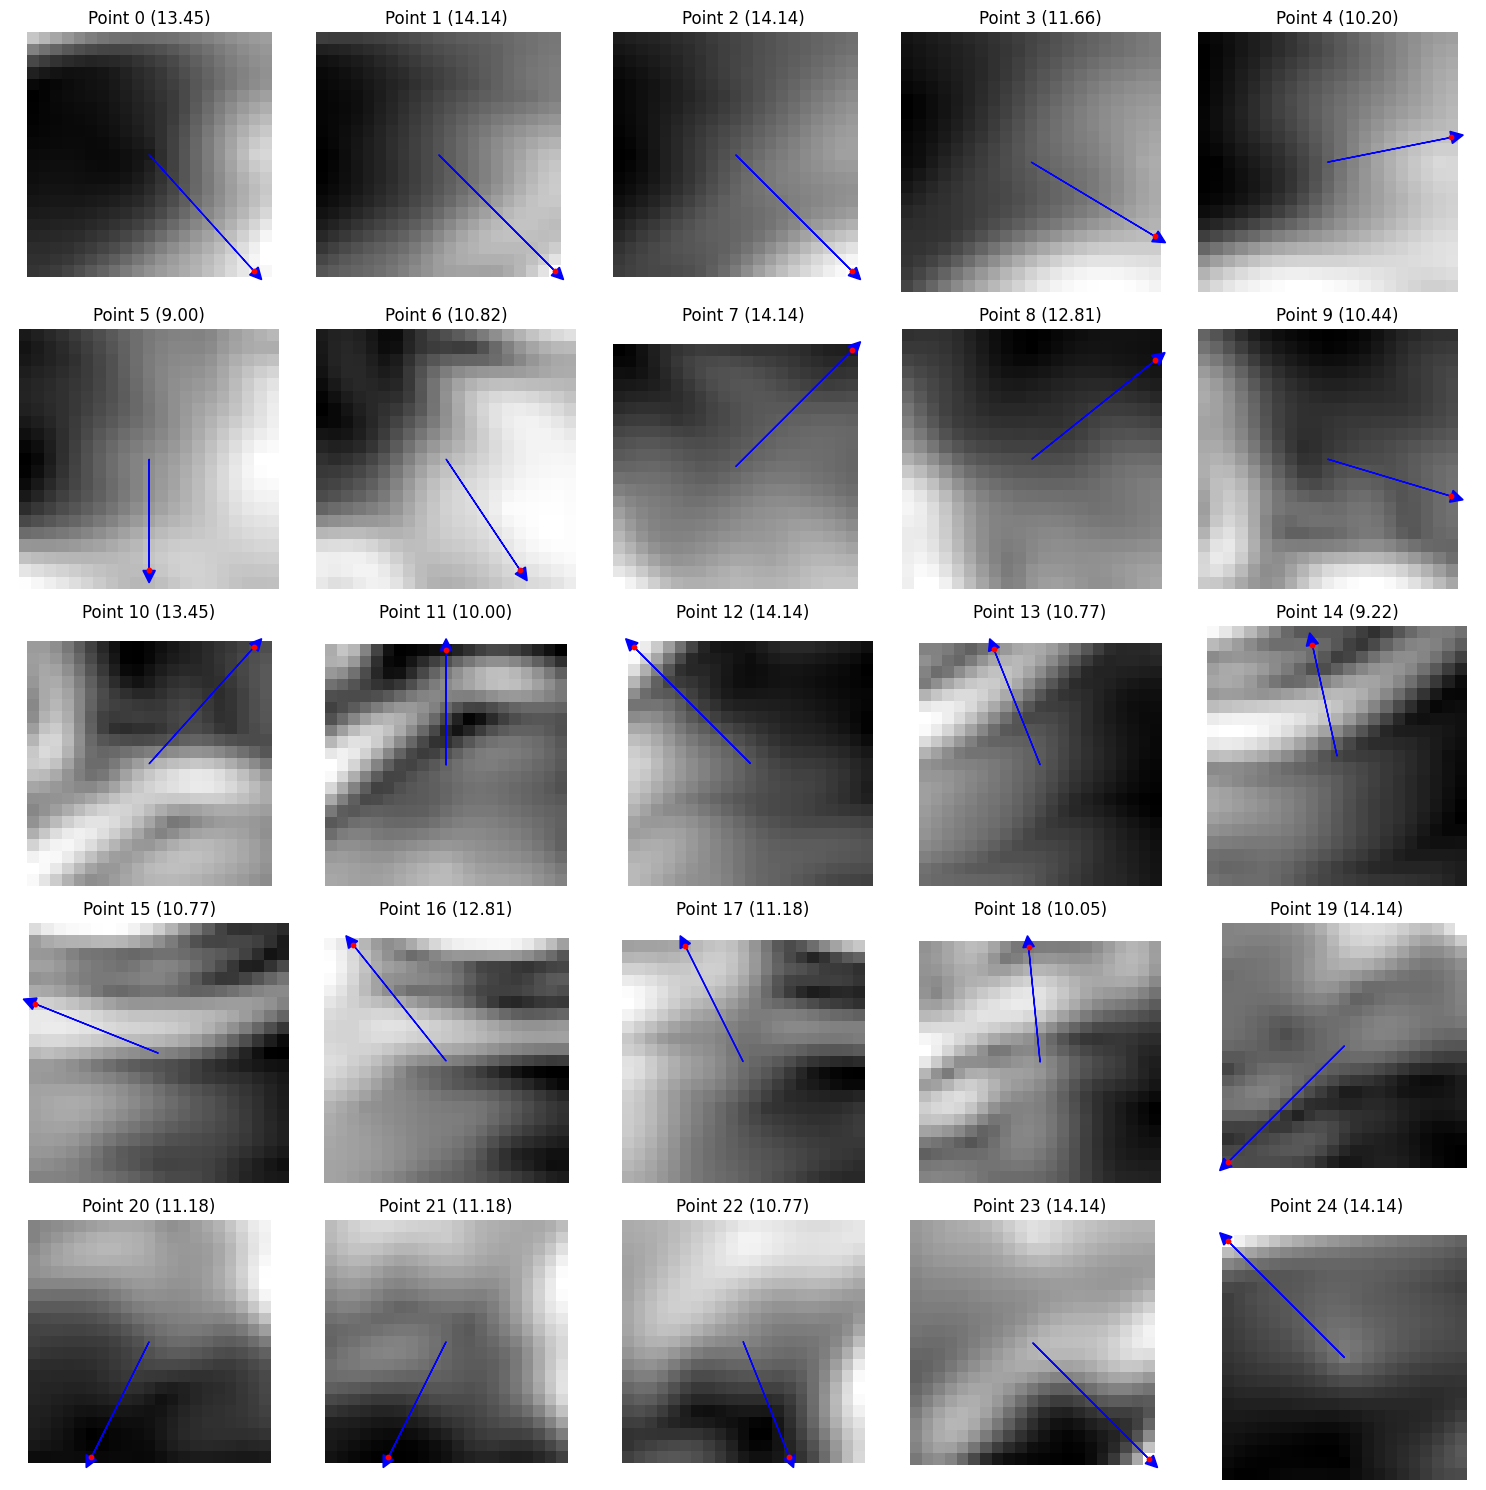

In [408]:
showEnergyFunctionPatches(curve_resampled, mag, window_size=20, alpha=0.01, beta=0.08)

In [409]:
def updateCurve(curve, gradient_image_, window_size=20, alpha=0.05, beta=0.05):
    # for each point in the curve, calculate the energy function
    # and find the maximum value in the patch
    # use the calculateWindowEnergyFunction function
    # and the findMaximumInPatch function
    # update the curve with the new point
    # return the new curve
    new_curve = np.zeros_like(curve)

    for i in range(curve.shape[0]):
        patch = calculateWindowEnergyFunction(
            curve[i], curve[(i+1)%curve.shape[0]], curve[i-1], 
            gradient_image_, window_size, alpha, beta
        )
        max_idx = findMaximumInPatch(patch, curve[i])

        # advance the curve by 2 pixels in the direction of the maximal point
        direction = curve[i] - max_idx
        direction_norm = np.linalg.norm(direction)
        if direction_norm > 0:
            new_curve[i] = curve[i] + (2 / direction_norm) * direction
        else:
            new_curve[i] = curve[i]

    return new_curve

In [410]:
# update the curve a few times
# display the updated curve on the gradient image
new_curve = curve_resampled
for i in range(30):
    # set the last point to the first point
    new_curve[-1] = new_curve[0]
    # resample the curve to a uniform distance using the resampleCurve function
    new_curve = resampleCurveUniform(new_curve)
    # update the curve using the updateCurve function
    # use the alpha and beta parameters to weight the two terms
    # use the window_size parameter to set the size of the window
    # the parameters that worked for me are window_size=20, alpha=0.01, beta=0.08
    new_curve = updateCurve(new_curve, mag, window_size=20, alpha=0.01, beta=0.08)

(161.52097204588998, 24.0724295823413)

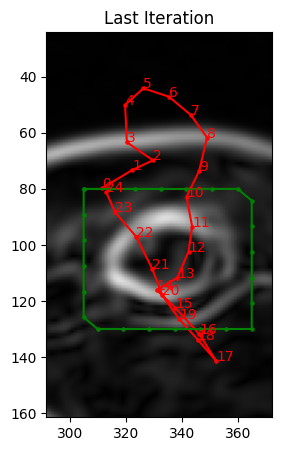

In [411]:
plt.figure(figsize=(5,5))
plt.imshow(mag, cmap='gray')
plt.plot(new_curve[:,0], new_curve[:,1], c='r')
plt.scatter(new_curve[:,0], new_curve[:,1], c='r', s=5)
# show the point index on the image next to the point
for i in range(new_curve.shape[0]):
    plt.text(new_curve[i,0], new_curve[i,1], str(i), color='r')
# show the original curve in green
plt.plot(curve_resampled[:,0], curve_resampled[:,1], c='g')
plt.scatter(curve_resampled[:,0], curve_resampled[:,1], c='g', s=5)
plt.title('Last Iteration')
plt.xlim(new_curve[:,0].min() - 20, new_curve[:,0].max() + 20)
plt.ylim(new_curve[:,1].max() + 20, new_curve[:,1].min() - 20)

That's a wrap!